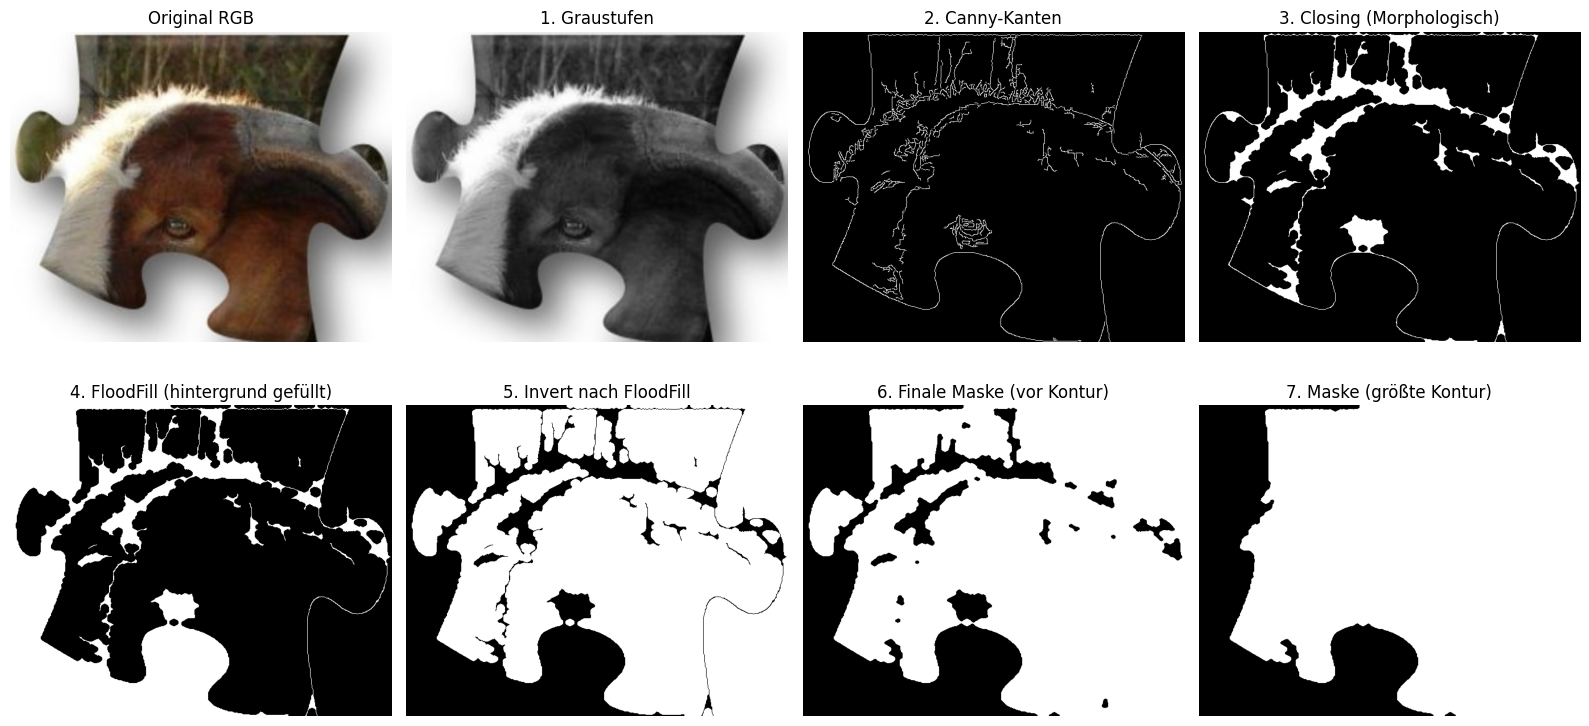

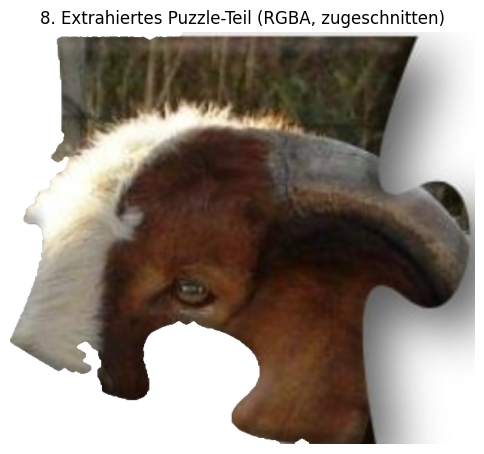

In [381]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def extract_puzzle_piece_edge_based_with_plots(image_path: str):
    """
    Führt denselben Ablauf wie extract_puzzle_piece_edge_based durch,
    gibt jedoch alle Zwischenschritte als Plots aus:
      1. Graustufen
      2. Canny-Kanten
      3. Morphologisches Closing
      4. FloodFill-Füllung und Invertierung
      5. Final Mask vor Konturfilterung
      6. Maske nach Kontur-Füllung (nur größte Kontur)
      7. Endgültiges RGBA-Ergebnis (zugeschnitten)

    Args:
        image_path (str): Pfad zum Eingangsbild (RGB).
    """
    # -------------------------------
    # 1. Bild laden & Graustufen
    # -------------------------------
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Bild '{image_path}' konnte nicht geladen werden.")

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # -------------------------------
    # 2. Canny-Kanten
    # -------------------------------
    edges = cv2.Canny(gray, threshold1=10, threshold2=100)

    # -------------------------------
    # 3. Morphologisches Closing (Lücken schließen)
    # -------------------------------
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    # -------------------------------
    # 4. FloodFill, um alle Löcher (innerhalb der Kontur) zu füllen
    # -------------------------------
    h, w = closed.shape
    floodfill_mask = np.zeros((h + 2, w + 2), np.uint8)
    filled = closed.copy()
    cv2.floodFill(filled, floodfill_mask, seedPoint=(0, 0), newVal=255)

    inv_filled = cv2.bitwise_not(filled)

    # Nochmals Closing für kleine Lücken
    final_mask_before = cv2.morphologyEx(inv_filled, cv2.MORPH_CLOSE, kernel, iterations=1)

    # -------------------------------
    # 5. Größte Kontur aus final_mask_before auswählen
    # -------------------------------
    contours, _ = cv2.findContours(final_mask_before,
                                   mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise RuntimeError("Keine Konturen gefunden – ggf. kein Puzzle erkennbar.")

    largest_contour = max(contours, key=cv2.contourArea)

    mask_clean = np.zeros_like(final_mask_before)
    cv2.drawContours(mask_clean, [largest_contour], contourIdx=-1, color=255, thickness=cv2.FILLED)

    # -------------------------------
    # 6. RGBA-Bild erstellen und zuschneiden
    # -------------------------------
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    alpha = mask_clean.copy()
    rgba = np.dstack((img_rgb, alpha))

    ys, xs = np.where(mask_clean == 255)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    cropped = rgba[y0 : y1 + 1, x0 : x1 + 1]
    result_pil = Image.fromarray(cropped, mode="RGBA")

    # -------------------------------
    # 7. Plots anzeigen
    # -------------------------------
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    # 1) Original (RGB) als Referenz
    img_rgb_disp = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb_disp)
    axes[0].set_title("Original RGB")
    axes[0].axis("off")

    # 2) Graustufen
    axes[1].imshow(gray, cmap="gray")
    axes[1].set_title("1. Graustufen")
    axes[1].axis("off")

    # 3) Canny-Kanten
    axes[2].imshow(edges, cmap="gray")
    axes[2].set_title("2. Canny-Kanten")
    axes[2].axis("off")

    # 4) Morphologisches Closing
    axes[3].imshow(closed, cmap="gray")
    axes[3].set_title("3. Closing (Morphologisch)")
    axes[3].axis("off")

    # 5) FloodFill-Füllung
    axes[4].imshow(filled, cmap="gray")
    axes[4].set_title("4. FloodFill (hintergrund gefüllt)")
    axes[4].axis("off")

    # 6) Inversion nach FloodFill
    axes[5].imshow(inv_filled, cmap="gray")
    axes[5].set_title("5. Invert nach FloodFill")
    axes[5].axis("off")

    # 7) Final mask vor Kontur-Füllung
    axes[6].imshow(final_mask_before, cmap="gray")
    axes[6].set_title("6. Finale Maske (vor Kontur)")
    axes[6].axis("off")

    # 8) Maske nach Kontur-Füllung (mask_clean)
    axes[7].imshow(mask_clean, cmap="gray")
    axes[7].set_title("7. Maske (größte Kontur)")
    axes[7].axis("off")

    plt.tight_layout()
    plt.show()

    # -------------------------------
    # 8. Finales Ergebnis anzeigen
    # -------------------------------
    plt.figure(figsize=(6, 6))
    plt.imshow(result_pil)
    plt.title("8. Extrahiertes Puzzle-Teil (RGBA, zugeschnitten)")
    plt.axis("off")
    plt.show()

    return result_pil


# Beispielaufruf:
img = extract_puzzle_piece_edge_based_with_plots("ziegepiece.jpg")


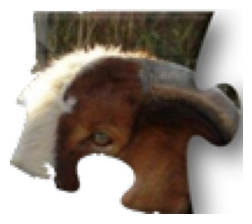

In [382]:
from PIL import Image
import matplotlib.pyplot as plt

# Angenommen, img ist dein bereits extrahiertes RGBA-Puzzleteil (ein PIL-Image)
orig_w, orig_h = img.size

# 1. Neue Breite auf 100 festlegen und Höhe proportional berechnen
new_w = 100
new_h = int(orig_h * (new_w / orig_w))

# 2. Bild skalieren (LANCZOS-Filter = äquivalent zum alten ANTIALIAS)
#    Je nach Pillow-Version kann man auch Image.Resampling.LANCZOS verwenden.
try:
    # Pillow ≥ 9.1.0
    img_100px = img.resize((new_w, new_h), resample=Image.LANCZOS)
except AttributeError:
    # Falls Resampling bzw. LANCZOS nicht existiert (ältere Version), einfach so:
    img_100px = img.resize((new_w, new_h))

# 3. Optional: Resultat anzeigen
plt.figure(figsize=(3, 3))
plt.imshow(img_100px)
plt.axis("off")
plt.show()

# 4. Optional: Speichern
img_100px.save("puzzle_clean_100px.png")


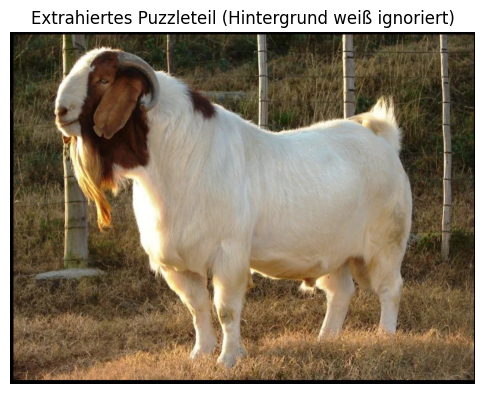

In [383]:
img_full = extract_puzzle_piece_ignore_white_bg("ziegefull.jpg", white_threshold=170, show=True)
# Optional speichern:
img_full.save("puzzle_clean_full.png")


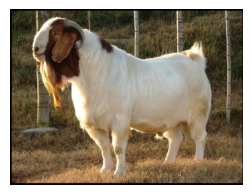

In [384]:
from PIL import Image
import matplotlib.pyplot as plt

# Angenommen, img ist dein bereits extrahiertes RGBA-Puzzleteil (ein PIL-Image)
orig_w, orig_h = img_full.size

# 1. Neue Breite auf 400 festlegen und Höhe proportional berechnen
new_w = 500
new_h = int(orig_h * (new_w / orig_w))

# 2. Bild skalieren (LANCZOS-Filter = äquivalent zum alten ANTIALIAS)
#    Je nach Pillow-Version kann man auch Image.Resampling.LANCZOS verwenden.
try:
    # Pillow ≥ 9.1.0
    img_400px = img_full.resize((new_w, new_h), resample=Image.LANCZOS)
except AttributeError:
    # Falls Resampling bzw. LANCZOS nicht existiert (ältere Version), einfach so:
    img_400px = img_full.resize((new_w, new_h))

# 3. Optional: Resultat anzeigen
plt.figure(figsize=(3, 3))
plt.imshow(img_400px)
plt.axis("off")
plt.show()

# 4. Optional: Speichern
img_400px.save("puzzle_clean_400px.png")


In [385]:
import cv2
import numpy as np
from PIL import Image


def match_template_with_rotations_and_draw_box(img_pil: Image.Image,
                                               tpl_pil: Image.Image,
                                               method: int = cv2.TM_CCOEFF_NORMED) -> Image.Image:
    """
    Führt Template-Matching für ein PIL-Image gegen ein Template durch,
    wobei transparente Pixel im Template ignoriert werden. Das Template
    wird in den Rotationen 0°, 90°, 180° und 270° ausprobiert. Die beste
    Übereinstimmung (höchste Korrelation bzw. niedrigster Fehler bei
    SQDIFF-Methoden) wird ausgewählt, und um diese Position wird eine
    grüne Box mit der Größe des entsprechend rotierten Templates gezeichnet.

    Args:
        img_pil (PIL.Image.Image):   Referenzbild (RGB oder RGBA).
        tpl_pil (PIL.Image.Image):   Template-/Filter-Bild (RGB oder RGBA).
        method (int):                OpenCV-Matching-Methode 
                                     (z.B. cv2.TM_CCOEFF_NORMED,
                                     cv2.TM_SQDIFF_NORMED, ...).

    Returns:
        PIL.Image.Image: Referenzbild (RGBA) mit eingezeichneter Bounding-Box
                         um die beste Übereinstimmung (inkl. Rotation).
    """
    # --------------------------------------------------
    # 1. Referenzbild: PIL → NumPy → BGR
    # --------------------------------------------------
    img_rgb = img_pil.convert("RGB")
    arr_img_rgb = np.array(img_rgb)                    # shape = (H_img, W_img, 3)
    img_bgr = cv2.cvtColor(arr_img_rgb, cv2.COLOR_RGB2BGR)

    

    use_min = (method == cv2.TM_SQDIFF or method == cv2.TM_SQDIFF_NORMED)
    best_score = np.inf if use_min else -np.inf
    best_top_left = (0, 0)
    best_angle = 0
    best_tpl_size = (0, 0)

    # --------------------------------------------------
    # 2. Über alle Rotationen loopen: 0°, 90°, 180°, 270°
    # --------------------------------------------------
    for angle in (0, 90, 180, 270):
        # 2.1 Template rotieren ↦ RGBA
        rotated_tpl_rgba = tpl_pil.rotate(angle, expand=True).convert("RGBA")
        arr_tpl_rgba = np.array(rotated_tpl_rgba)       # shape = (h_t, w_t, 4)
        # 2.2 Maske aus Alpha-Kanal: 255 wo Alpha>0, sonst 0
        alpha = arr_tpl_rgba[:, :, 3]
        tpl_mask = np.where(alpha > 0, 255, 0).astype(np.uint8)  # shape = (h_t, w_t)

        # 2.3 RGB-Teil des Templates extrahieren und zu BGR wandeln
        tpl_rgb = arr_tpl_rgba[:, :, :3]
        tpl_bgr = cv2.cvtColor(tpl_rgb, cv2.COLOR_RGB2BGR)
        tpl_h, tpl_w = tpl_bgr.shape[:2]

        # 2.4 Template-Matching mit Maske
        #      matchTemplate erwartet mask als 8-bit single channel
        res = cv2.matchTemplate(img_bgr, tpl_bgr, method, mask=tpl_mask)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        if use_min:
            score = min_val
            top_left = min_loc
        else:
            score = max_val
            top_left = max_loc

        # 2.5 Prüfen, ob dieser Score besser ist als bisher
        if (use_min and score < best_score) or (not use_min and score > best_score):
            best_score = score
            best_top_left = top_left
            best_angle = angle
            best_tpl_size = (tpl_w, tpl_h)

    # --------------------------------------------------
    # 3. Box-Koordinaten für die beste Übereinstimmung
    # --------------------------------------------------
    w_box, h_box = best_tpl_size
    x0, y0 = best_top_left
    x1, y1 = x0 + w_box, y0 + h_box

    # --------------------------------------------------
    # 4. Rechteck im Referenzbild einzeichnen (RGBA-Ausgabe)
    # --------------------------------------------------
    # 4.1 Referenzbild BGR → RGB
    img_rgb_again = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 4.2 Alpha-Kanal (255 = voll deckend)
    h_img, w_img = img_rgb_again.shape[:2]
    alpha_full = np.ones((h_img, w_img), dtype=np.uint8) * 255

    # 4.3 Stapel RGB + Alpha → RGBA
    img_rgba = np.dstack((img_rgb_again, alpha_full))

    # 4.4 Grüne Box zeichnen (RGBA = (0,255,0,255))
    cv2.rectangle(img_rgba,
                  pt1=(x0, y0),
                  pt2=(x1, y1),
                  color=(0, 255, 0, 255),
                  thickness=2)

    # --------------------------------------------------
    # 5. In PIL-Image umwandeln und zurückgeben
    # --------------------------------------------------
    result_pil = Image.fromarray(img_rgba, mode="RGBA")
    print(f"Beste Übereinstimmung: Score={best_score:.4f}, Winkel={best_angle}°, Position={best_top_left}")
    return result_pil


Beste Übereinstimmung: Score=0.5545, Winkel=180°, Position=(66, 59)


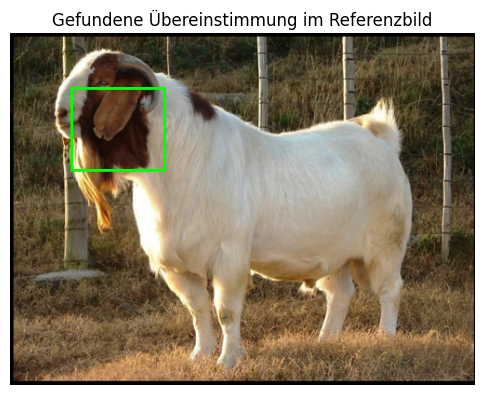

In [386]:


# Default-Methode: TM_CCOEFF_NORMED → höhere Korrelation = besser
result = match_template_with_rotations_and_draw_box(img_400px, img_100px, method=cv2.TM_CCOEFF_NORMED)

# Anzeige mit matplotlib (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(result)
plt.axis("off")
plt.title("Gefundene Übereinstimmung im Referenzbild")
plt.show()

# Abspeichern (optional)
result.save("matched_with_box.png")

C:\Users\STI\AppData\Local\Temp\ipykernel_34884\1293154904.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


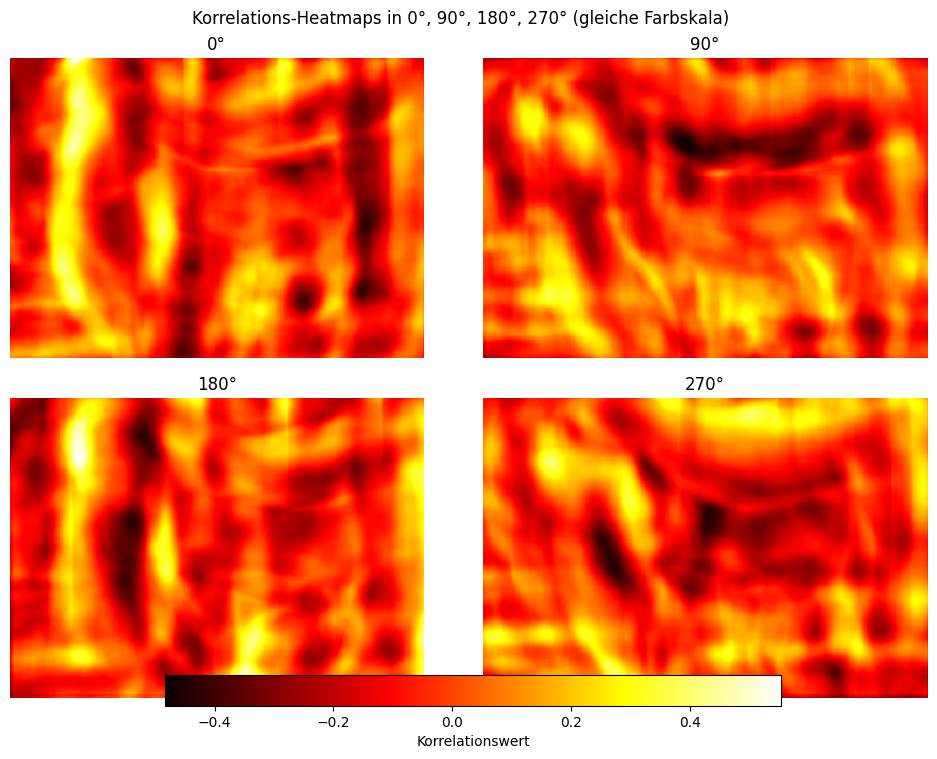

In [387]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def show_correlation_heatmap_with_rotations(img_pil: Image.Image,
                                            tpl_pil: Image.Image,
                                            method: int = cv2.TM_CCOEFF_NORMED):
    """
    Zeigt vier Heatmaps (0°, 90°, 180°, 270°) mit einheitlicher Farbskala,
    wobei transparente Template-Pixel (Alpha=0) ausgelassen werden.

    Args:
        img_pil (PIL.Image.Image): Referenzbild (RGB oder RGBA).
        tpl_pil (PIL.Image.Image): Template-Bild (RGBA oder RGB).
        method (int):              OpenCV-Matching-Methode,
                                   z.B. cv2.TM_CCOEFF_NORMED.

    Hinweis:
        Nur die Modi TM_SQDIFF*, TM_CCORR_NORMED und TM_CCOEFF_NORMED
        unterstützen eine Maske in matchTemplate.
    """
    angles = (0, 90, 180, 270)

    # 1. Referenzbild → BGR (RGB ignoriert Alpha)
    arr_img = np.array(img_pil.convert("RGB"))
    img_bgr = cv2.cvtColor(arr_img, cv2.COLOR_RGB2BGR)

    # 2. Sammle alle Res-Matrizen
    res_list = []
    for angle in angles:
        # 2.1 Template rotieren + zu RGBA für Alpha
        tpl_rot_rgba = tpl_pil.rotate(angle, expand=True).convert("RGBA")
        arr_tpl_rgba = np.array(tpl_rot_rgba)              # (h_t, w_t, 4)

        # 2.2 Erzeuge Maske: 255 wo Alpha>0, sonst 0
        alpha = arr_tpl_rgba[:, :, 3]
        tpl_mask = (alpha > 0).astype(np.uint8) * 255      # 8-bit Maske

        # 2.3 RGB-Teil → BGR
        tpl_rgb = arr_tpl_rgba[:, :, :3]
        tpl_bgr = cv2.cvtColor(tpl_rgb, cv2.COLOR_RGB2BGR)

        # 2.4 Template-Matching mit Maske
        res = cv2.matchTemplate(img_bgr, tpl_bgr, method, mask=tpl_mask)
        res_list.append(res)

    # 3. Globales Minimum und Maximum
    all_min = min(res.min() for res in res_list)
    all_max = max(res.max() for res in res_list)

    # 4. Plotten mit einheitlicher Skala
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.ravel()

    for idx, angle in enumerate(angles):
        res = res_list[idx]
        ax = axs[idx]
        heat = ax.imshow(res, cmap="hot", vmin=all_min, vmax=all_max, interpolation="nearest")
        ax.set_title(f"{angle}°")
        ax.axis("off")

    # 5. Gemeinsame horizontale Colorbar darunter
    cbar = fig.colorbar(heat,
                        ax=axs,
                        orientation="horizontal",
                        fraction=0.05,
                        pad=0.08)
    cbar.set_label("Korrelationswert")

    fig.suptitle("Korrelations-Heatmaps in 0°, 90°, 180°, 270° (gleiche Farbskala)")
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, bottom=0.12)
    plt.show()


# Beispielaufruf (img_400px und img_100px sind bereits PIL-Images):
# show_correlation_heatmap_with_rotations(img_400px, img_100px, method=cv2.TM_CCOEFF_NORMED)
show_correlation_heatmap_with_rotations(img_400px, img_100px)